# Olympic Athletes' Height Analysis
## Summer Olympic Games (1960-2016)
### blah, blah, blah

### Import Dependencies

In [78]:
import pandas as pd
import numpy as np
import os
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm 

### Importing Clean, Summer Men's data (for 84 events)

In [79]:
# grab the cleaned, men's summer games olympic data
olympic_file = os.path.join("..","data", "cleanData","Mens_OlympicData_1960_2016.csv")
olympic_df = pd.read_csv(olympic_file, encoding="ISO-8859-1")

# To get the raw data count, commented out to keep the original df .head() results prominent
athlete_count = len(olympic_df)

# preview the raw data
olympic_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,MedalYN,Sub Event,Games Count
0,1,A Dijiang,M,24.0,70.866142,176.369954,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,No,Basketball Basketball,15
1,136,Alessandro Abbio,M,29.0,76.771654,187.393076,Italy,ITA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,NaN,No,Basketball Basketball,15
2,192,Ahmed El-Sayed Abdel Hamid Mobarak,M,25.0,74.409449,187.393076,Egypt,EGY,1972 Summer,1972,Summer,Munich,Basketball,Basketball Men's Basketball,NaN,No,Basketball Basketball,15
3,199,Amir Abdel Meguid,M,23.0,70.078740,147.709836,Egypt,EGY,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,NaN,No,Basketball Basketball,15
4,199,Amir Abdel Meguid,M,27.0,70.078740,147.709836,Egypt,EGY,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Men's Basketball,NaN,No,Basketball Basketball,15


### Importing the global height data

In [80]:
# grab the cleaned, men's summer games olympic data
global_file = os.path.join("..","data", "cleanData","Mens_WorldHeight_1960_2016.csv")
global_df = pd.read_csv(global_file, encoding="ISO-8859-1")

# preview the raw data
global_df.head()

,Country,ISO,Sex,Year of birth,Mean height (cm),Mean height lower 95% uncertainty interval (cm),Mean height upper 95% uncertainty interval (cm),Olympic Year,Mean height (inches),Mean height lower 95% uncertainty interval (inches),Mean height upper 95% uncertainty interval (inches)
0,Afghanistan,AFG,Men,1941,163.504155,158.335069,168.802901,1960,64.371714,62.336641,66.457835
1,Albania,ALB,Men,1941,169.797726,167.489856,172.040004,1960,66.849498,65.940888,67.732285
2,Algeria,DZA,Men,1941,169.838408,168.464552,171.205536,1960,66.865515,66.324627,67.403755
3,American Samoa,ASM,Men,1941,171.633535,170.764394,172.527003,1960,67.572258,67.230076,67.924017
4,Andorra,AND,Men,1941,169.426241,164.365804,174.455640,1960,66.703245,64.710946,68.683323


### Compare the overall averages (all athletes to global height data) by year

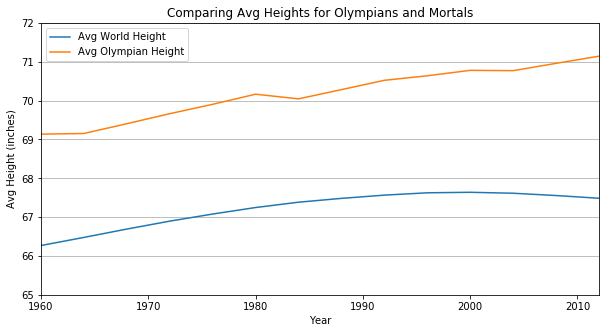

In [82]:
# group the mens data, average by year
olympicAvg_Year = pd.DataFrame(olympic_df.groupby('Year')['Height'].mean().reset_index())

# rename column
olympicAvg_Year = olympicAvg_Year.rename(columns={'Height':'Avg Olympian Height'})

# group the global data, average height by year
globalAvg_Year = pd.DataFrame(global_df.groupby('Olympic Year')['Mean height (inches)'].mean().reset_index())

# rename column
globalAvg_Year = globalAvg_Year.rename(columns={'Olympic Year':'Year','Mean height (inches)':'Avg World Height'})

# combine to plot
allAvg_Year = globalAvg_Year.merge(olympicAvg_Year,on='Year')

allAvg_Year.head()

overall_chart = allAvg_Year.plot(
    x='Year',
    y=['Avg World Height','Avg Olympian Height'],
    figsize=(10,5),
    title='Comparing Avg Heights for Olympians and Mortals',
    ylim = (65,72)
)

# add axis labels
overall_chart.set_xlabel("Year")
overall_chart.set_ylabel('Avg Height (inches)')
overall_chart.yaxis.grid(True)

overall_chart.get_figure().savefig('..\images\gods_mortals.pdf')

### is the difference in mean significant?

In [83]:
# perform a t-test on the 2 means
(t_stat, p) = stats.ttest_ind(allAvg_Year['Avg World Height'], allAvg_Year['Avg Olympian Height'])

# print results
print(f'The variance between the avg Olympian and the average peon, p={p}, is significant.')

The variance between the avg Olympian and the average peon, p=1.842081129687331e-13, is significant.


### See if the Olympic heights is interesting by sport...

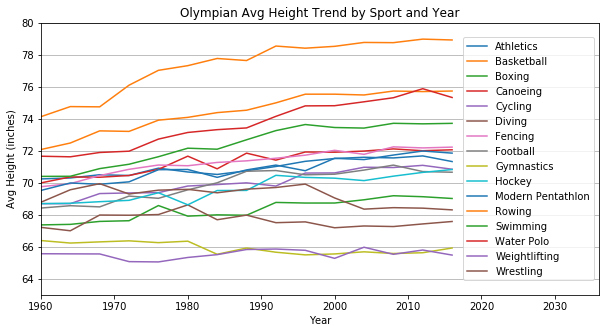

In [84]:
# get the average height by sport
sport_avg = pd.DataFrame(olympic_df.groupby(['Sport','Year'])['Height'].mean().reset_index())

sport_pvt = sport_avg.pivot(index='Year', columns='Sport', values = 'Height').reset_index()

sports = [
    'Athletics',
    'Basketball',
    'Boxing',
    'Canoeing',
    'Cycling',
    'Diving',
    'Fencing',
    'Football',
    'Gymnastics',
    'Hockey',
    'Modern Pentathlon',
    'Rowing',
    'Swimming',
    'Water Polo',
    'Weightlifting',
    'Wrestling'
]

# plot (probably a better way to do this...)
sport_chart = sport_pvt.plot(
    x = 'Year', 
    y = sports,
    figsize=(10,5),
    title='Olympian Avg Height Trend by Sport and Year',
    ylim = (63,80),
    xlim = (1960, 2036)
)

# add axis labels
sport_chart.set_xlabel("Year")
sport_chart.set_ylabel('Avg Height (inches)')
sport_chart.yaxis.grid(True)
sport_chart.legend(loc='right')

sport_chart.get_figure().savefig('..\images\sports.pdf')


### Athletics is pretty flat, lets explode it to see if there is variance within the sport (by event)

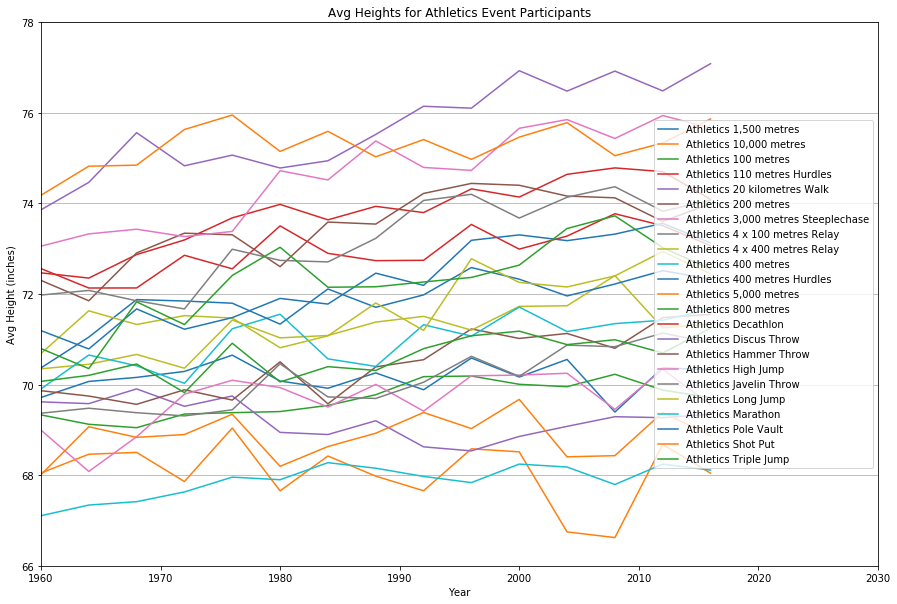

In [87]:
# new df for just athletics 
athletics_df = olympic_df.loc[olympic_df['Sport']=='Athletics']

# calculate the average by year and sub-event
athletics_Avg = pd.DataFrame(athletics_df.groupby(['Sub Event','Year'])['Height'].mean().reset_index())

# rename column
athletics_Avg = athletics_Avg.rename(columns={'Height':'Avg Height'})

# pivot for charting
athletics_pivot = athletics_Avg.pivot(index='Year', columns='Sub Event', values = 'Avg Height').reset_index()

# build the column list
columns = []
for columnName, columnValues in athletics_pivot.iteritems():
    if columnName != 'Year':
        columns.append(columnName)

athletic_chart = athletics_pivot.plot(
    x='Year',
    y = columns,
    figsize=(15,10),
    title='Avg Heights for Athletics Event Participants',
    ylim = (66,78),
    xlim = (1960, 2030)    
)

athletic_chart.set_xlabel("Year")
athletic_chart.set_ylabel('Avg Height (inches)')
athletic_chart.yaxis.grid(True)
athletic_chart.legend(loc='right')

athletic_chart.get_figure().savefig('..\images\\athletics.png')

### Looking at gymnastics

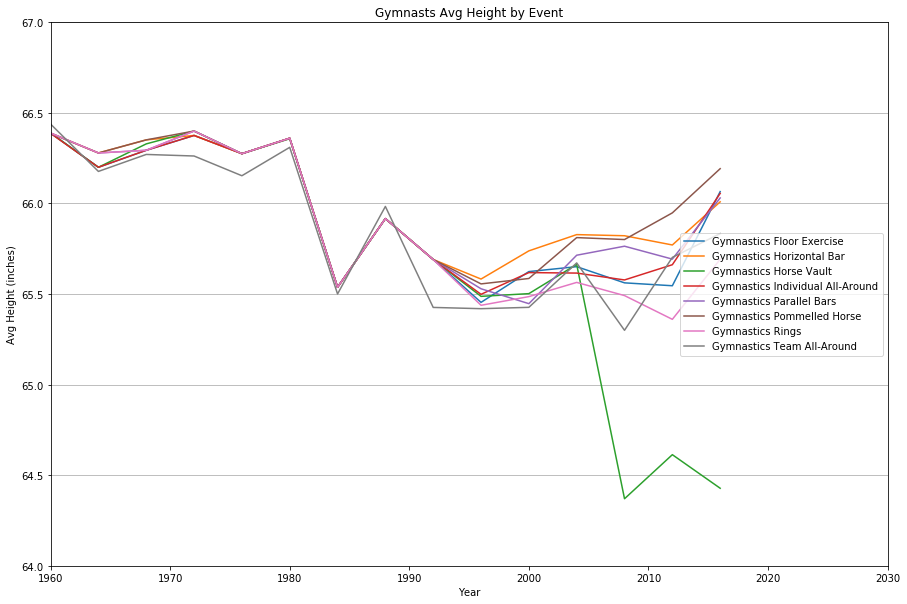

In [67]:
# new df for just athletics 
gym_df = olympic_df.loc[olympic_df['Sport']=='Gymnastics']

# calculate the average by year and sub-event
gym_Avg = pd.DataFrame(gym_df.groupby(['Sub Event','Year'])['Height'].mean().reset_index())

# rename column
gym_Avg = gym_Avg.rename(columns={'Height':'Avg Height'})

# pivot for charting
gym_pivot = gym_Avg.pivot(index='Year', columns='Sub Event', values = 'Avg Height').reset_index()

# build the column list
columns = []
for columnName, columnValues in gym_pivot.iteritems():
    if columnName != 'Year':
        columns.append(columnName)

gym_chart = gym_pivot.plot(
    x ='Year',
    y = columns,
    figsize=(15,10),
    title='Gymnasts Avg Height by Event',
    ylim = (64,67),
    xlim = (1960, 2030)    
)

gym_chart.set_xlabel("Year")
gym_chart.set_ylabel('Avg Height (inches)')
gym_chart.yaxis.grid(True)
gym_chart.legend(loc='right')

gym_chart.get_figure().savefig('..\images\gymers.png')

### Zooming in on swimming...

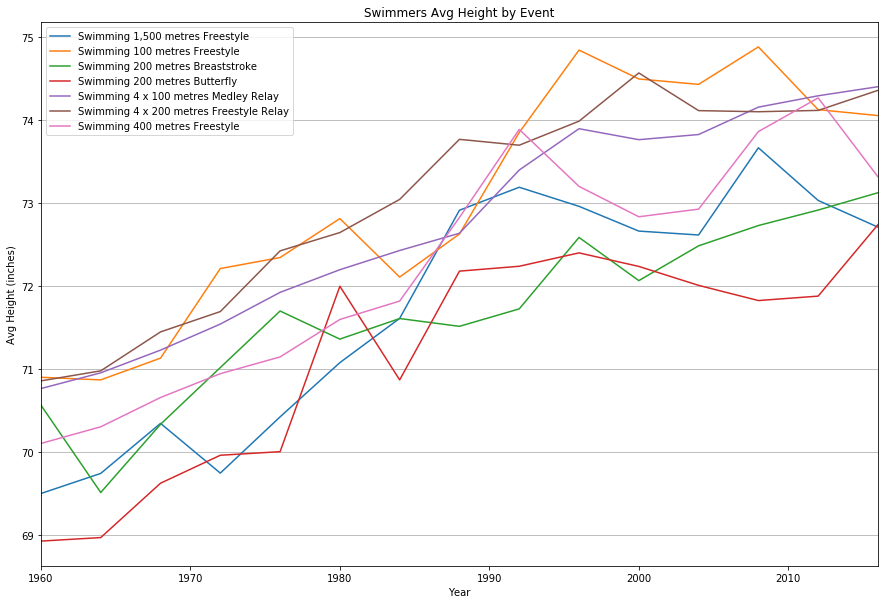

In [69]:
# new df for just athletics 
swim_df = olympic_df.loc[olympic_df['Sport']=='Swimming']

# calculate the average by year and sub-event
swim_Avg = pd.DataFrame(swim_df.groupby(['Sub Event','Year'])['Height'].mean().reset_index())

# rename column
swim_Avg = swim_Avg.rename(columns={'Height':'Avg Height'})

# pivot for charting
swim_pivot = swim_Avg.pivot(index='Year', columns='Sub Event', values = 'Avg Height').reset_index()

# build the column list
columns = []
for columnName, columnValues in swim_pivot.iteritems():
    if columnName != 'Year':
        columns.append(columnName)

swim_chart = swim_pivot.plot(
    x='Year',
    y=columns,
    figsize=(15,10),
    title='Swimmers Avg Height by Event',
#     ylim = (64,67),
    xlim = (1960, 2016)    
)

swim_chart.set_xlabel("Year")
swim_chart.set_ylabel('Avg Height (inches)')
swim_chart.yaxis.grid(True)
swim_chart.legend(loc='best')  

swim_chart.get_figure().savefig('..\images\swimmers.png')

### By Event, is the mean height significantly different that the global average?

In [10]:
globalAvg_Year.head()

,Year,Avg World Height
0,1960,66.269049
1,1964,66.477608
2,1968,66.692856
3,1972,66.896947
4,1976,67.079816


In [11]:
# get the average by sub-event and year
subevent_year_avg = pd.DataFrame(olympic_df.groupby(['Sub Event','Year'])['Height'].mean().reset_index())

# rename column
subevent_year_avg = subevent_year_avg.rename(columns={'Height':'Avg Height'})

# pivot
subevent_pivot = subevent_year_avg.pivot(index='Year', columns='Sub Event', values = 'Avg Height').reset_index()

# merge with global height avg
# subevent_pivot = subevent_pivot.merge(globalAvg_Year, on='Year')

# loop through, calculating a t-test for each event (against world height avg)
sub_events = []
t_stats = []
ps = []

for columnName, columnData in subevent_pivot.iteritems():
    # if not the year, perform the t-test
    if columnName != 'Year':
        # t-test
        (t_stat, p) = stats.ttest_ind(columnData.values, globalAvg_Year['Avg World Height'])
                
        # append the values to lists...
        sub_events.append(columnName)
        t_stats.append(t_stat)
        ps.append(p)


        
        
# put results into a dataframe
subEvent_vs_global = pd.DataFrame({
    'Sub Event': sub_events,
    't Stat': t_stats,
    'p': ps
})



# find out where variance in height matters (both tails)
sigEvent_Global = subEvent_vs_global.loc[subEvent_vs_global['p']<0.05]

# sigEvent_Global.head(20)

subevents_sig_count = len(sigEvent_Global)

print(f'Of the 84 events, the participants in {subevents_sig_count} of them are significantly different than the global height avg')


Of the 84 events, the participants in 82 of them are significantly different than the global height avg


### since so many p-values are close to zero, make sure it's ok

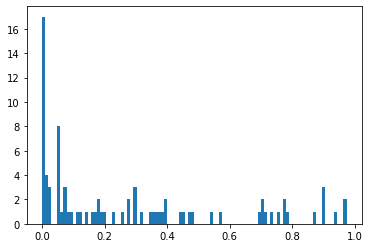

In [76]:
# multiple testing adjustment for p-values, since so many p values are significant
n, bins, patches = plt.hist(
    x=ps,
    bins=100
)

# pdist = plt.plot.bar(bins)
# breaking the p-values into 100 bins should spread the data out.  

### Which 2 events are not significantly different from global height avg?

In [13]:
# use loc...
unsigEvent_Global = subEvent_vs_global.loc[subEvent_vs_global['p']>=0.05]

unsigEvent_Global.head()

,Sub Event,t Stat,p
29,Boxing Lightweight,-0.666919,0.510483
39,Diving Platform,0.864365,0.395002


### Medalists vs losers...

In [14]:
# create 2 datasets, one for winners and one for losers
winners_df = olympic_df.loc[olympic_df['MedalYN']=='Yes']
losers_df = olympic_df.loc[olympic_df['MedalYN']=='No']

# get the avg heights by year and sub event
winners_avg = pd.DataFrame(winners_df.groupby(['Sub Event','Year'])['Height'].mean().reset_index())
losers_avg = pd.DataFrame(losers_df.groupby(['Sub Event','Year'])['Height'].mean().reset_index())

# rename columns
winners_avg = winners_avg.rename(columns={'Height':'Avg Height'})
losers_avg = losers_avg.rename(columns={'Height': 'Avg Height'})

# pivot each one...
winners_pivot = winners_avg.pivot(index='Year', columns='Sub Event', values = 'Avg Height').reset_index()
losers_pivot = losers_avg.pivot(index='Year', columns='Sub Event', values = 'Avg Height').reset_index()

# combine them all into 1 merge...
all_pivot = winners_pivot.merge(losers_pivot,on='Year')

# combined output
all_pivot.head()



Sub Event,Year,"Athletics 1,500 metres_x","Athletics 10,000 metres_x",Athletics 100 metres_x,Athletics 110 metres Hurdles_x,Athletics 20 kilometres Walk_x,Athletics 200 metres_x,"Athletics 3,000 metres Steeplechase_x",Athletics 4 x 100 metres Relay_x,Athletics 4 x 400 metres Relay_x,...,"Wrestling Featherweight, Freestyle_y","Wrestling Featherweight, Greco-Roman_y","Wrestling Heavyweight, Freestyle_y","Wrestling Heavyweight, Greco-Roman_y","Wrestling Light-Heavyweight, Freestyle_y","Wrestling Light-Heavyweight, Greco-Roman_y","Wrestling Middleweight, Freestyle_y","Wrestling Middleweight, Greco-Roman_y","Wrestling Welterweight, Freestyle_y","Wrestling Welterweight, Greco-Roman_y"
0,1960,69.947507,67.979003,72.309711,73.097113,70.341207,69.816273,67.716535,70.997375,71.751969,...,65.710536,65.673041,72.138098,73.053368,70.393701,70.416198,69.389764,69.010124,68.048073,68.298528
1,1964,70.997375,70.209974,69.553806,72.572178,70.472441,71.784777,69.553806,69.685039,72.178478,...,65.979620,65.541807,72.401575,73.474409,71.138704,71.994751,71.471835,70.773506,68.635171,68.577756
2,1968,72.047244,67.716535,70.734908,71.916010,69.816273,73.753281,69.685039,69.160105,71.391076,...,65.019685,65.768753,74.230494,73.851706,72.774076,72.652938,70.866142,70.447835,69.512795,68.875766
3,1972,71.259843,67.847769,72.047244,73.097113,70.866142,72.047244,69.160105,70.866142,70.472441,...,65.850736,65.526575,72.743792,72.118826,70.826772,72.125984,69.835021,70.103346,68.391451,68.479331
4,1976,72.965879,68.897638,71.522310,73.753281,69.816273,70.603675,71.391076,70.341207,72.309711,...,64.932508,65.466817,72.473753,72.598425,71.746179,72.637795,69.685039,70.472441,69.006999,68.687664


### perform t-tests on all 84 events, to see difference in height is significant between winners/losers

In [15]:
# initialize lists to capture t-test results
sub_events = []
t_stats = []
ps = []

for (xColumnName,xColumnData) in all_pivot.iteritems(): 
    
    # if the column ends in an x, calculate the t-test
    if  xColumnName[-2:]=='_x':
        
        # strip off the trailing _x so we can call the y version
        column = xColumnName.strip('_x')
        
        # loop through the columns one more time, to catch the Y version
        for (yColumnName, yColumnData) in all_pivot.iteritems():
            
            # if the y columname matches the x column namme base (column) + "_y", then do the t-test
            if yColumnName == column + '_y':
                
                # t-test
                (t_stat, p) = stats.ttest_ind(xColumnData.values, yColumnData.values)
                
                
                # append the values to lists...
                sub_events.append(column)
                t_stats.append(t_stat)
                ps.append(p)

# create a dataframe to display results
subEvent_df = pd.DataFrame({
    'Olympic Event': sub_events,
    'T_stat': t_stats,
    'p': ps
})

# find out where variance in height matters (both tails)
sigEvent = subEvent_df.loc[subEvent_df['p']<0.05]

sigEvent = sigEvent.sort_values(by=['p'])

sigEvent.head(50)

# len(sigEvent)

,Olympic Event,T_stat,p
2,Athletics 100 metres,6.094288,0.000001
10,Athletics 400 metres Hurdles,5.334984,0.000011
16,Athletics High Jump,4.382135,0.000150
52,Gymnastics Team All-Around,-4.229536,0.000226
9,Athletics 400 metres,4.060158,0.000358
48,Gymnastics Individual All-Around,-4.028421,0.000389
61,Swimming 100 metres Freestyle,3.878010,0.000582
63,Swimming 200 metres Butterfly,3.867884,0.000598
5,Athletics 200 metres,3.846759,0.000633
27,Boxing Light-Heavyweight,3.785355,0.000745
